In [9]:
import time
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import time


In [2]:
M = 40  
N = 40  
SNR_dB = np.arange(0, 26, 5)  
num_symbols = 20  # 1000

# Functions to generate QPSK symbols and add noise
def generate_qpsk_symbols(N, num_symbols):
    return (2 * np.random.randint(0, 2, (N, num_symbols)) - 1) + 1j * (2 * np.random.randint(0, 2, (N, num_symbols)) - 1)

def add_noise(y, snr_db):
    snr = 10**(snr_db / 10)
    noise_power = np.mean(np.abs(y)**2) / snr
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*y.shape) + 1j * np.random.randn(*y.shape))
    return y + noise

# Detection methods
def zero_forcing(H, y):
    H_pseudo_inv = np.linalg.pinv(H)
    return np.sign(np.real(H_pseudo_inv @ y)) + 1j * np.sign(np.imag(H_pseudo_inv @ y))

def mmse(H, y, snr):
    N0 = 1 / snr
    H_H = H.conj().T @ H
    W = np.linalg.inv(H_H + N0 * np.eye(H.shape[1])) @ H.conj().T
    return np.sign(np.real(W @ y)) + 1j * np.sign(np.imag(W @ y))

def lattice_reduction_aided(H, y, snr, method):
    # Lattice Reduction Aided Detection (ZF or MMSE)
    from scipy.linalg import qr
    H_tilde, _ = qr(H)  # QR decomposition of the channel matrix
    if method == "ZF":
        s_hat = zero_forcing(H_tilde, y)
    elif method == "MMSE":
        s_hat = mmse(H_tilde, y, snr)
    else:
        raise ValueError("Invalid method for LRA detection")
    return s_hat

# SDR detection with rank-1 approximation
def sdr_rank1_approximation(H, y):
    M, N = H.shape
    y = y[:, np.newaxis]  
    Q = np.block([
        [H.conj().T @ H, -H.conj().T @ y],
        [-y.conj().T @ H, np.array([[np.linalg.norm(y)**2]])]
    ])

    # Solve eigenvalue problem
    eigvals, eigvecs = eigh(Q)
    sdr_solution = eigvecs[:, -1]  
    
    # Extract the solution using rank-1 approximation
    s = np.sign(np.real(sdr_solution[:N])) + 1j * np.sign(np.real(sdr_solution[N:]))
    return s

# SDR detection with randomization using CVXPY
def sdr_randomization(H, y, num_randomizations=50):
    M, N = H.shape
    y = y[:, np.newaxis]  
    Q = np.block([
        [H.conj().T @ H, -H.conj().T @ y],
        [-y.conj().T @ H, np.array([[np.linalg.norm(y)**2]])]
    ])

    # Convert Q to real form
    Q_real = np.block([
        [np.real(Q), -np.imag(Q)],
        [np.imag(Q), np.real(Q)]
    ])

    # Solve the SDP relaxation using CVXPY
    X = cvx.Variable((2 * (N + 1), 2 * (N + 1)), symmetric=True)
    constraints = [X >> 0, cvx.diag(X) == 1]
    objective = cvx.Minimize(cvx.trace(Q_real @ X))
    prob = cvx.Problem(objective, constraints)
    prob.solve()

    # Extract the solution
    X_opt = np.array(X.value)

    # Ensure the covariance matrix is symmetric positive semidefinite
    X_opt = (X_opt + X_opt.T) / 2

    best_approx = None
    best_metric = float("inf")

    for _ in range(num_randomizations):
        try:
            random_vec = np.random.multivariate_normal(np.zeros(2 * (N + 1)), X_opt)
        except np.linalg.LinAlgError:
            random_vec = np.random.randn(2 * (N + 1))
        random_vec = np.sign(random_vec)
        random_vec_complex = random_vec[:N] + 1j * random_vec[N:2 * N]

        metric = random_vec_complex.conj().T @ Q[:N, :N] @ random_vec_complex
        if metric < best_metric:
            best_metric = metric
            best_approx = random_vec_complex

    return np.array(best_approx)

# Simulation results
ber_results = {
    "ZF": [],
    "MMSE-DF": [],
    "LRA-ZF-DF": [],
    "LRA-MMSE-DF": [],
    "SDR (Rank-1 Approx.)": [],
    "SDR (Randomization)": [],
    "Performance Lower Bound": []
}

for snr_db in SNR_dB:
    print("snr_db: ",snr_db)
    errors = {key: 0 for key in ber_results.keys()}

    for ii in range(num_symbols):
        print(ii)
   
        H = (np.random.randn(M, N) + 1j * np.random.randn(M, N)) / np.sqrt(2)
        s = generate_qpsk_symbols(N, 1).flatten()
        y = H @ s

        y_noisy = add_noise(y, snr_db)

        s_hat_zf = zero_forcing(H, y_noisy)
        s_hat_mmse = mmse(H, y_noisy, 10**(snr_db / 10))
        s_hat_lra_zf = lattice_reduction_aided(H, y_noisy, 10**(snr_db / 10), method="ZF")
        s_hat_lra_mmse = lattice_reduction_aided(H, y_noisy, 10**(snr_db / 10), method="MMSE")
        s_hat_sdr_rank1 = sdr_rank1_approximation(H, y_noisy)
        s_hat_sdr_random = sdr_randomization(H, y_noisy)

        errors["ZF"] += np.sum(s != s_hat_zf)
        errors["MMSE-DF"] += np.sum(s != s_hat_mmse)
        errors["LRA-ZF-DF"] += np.sum(s != s_hat_lra_zf)
        errors["LRA-MMSE-DF"] += np.sum(s != s_hat_lra_mmse)
        errors["SDR (Rank-1 Approx.)"] += np.sum(s != s_hat_sdr_rank1)
        errors["SDR (Randomization)"] += np.sum(s != s_hat_sdr_random)

    for key in ber_results.keys():
        if key == "Performance Lower Bound":
            ber_results[key].append(1 / (2**(snr_db / 10)))  # Example lower bound approximation
        else:
            ber_results[key].append(errors[key] / (num_symbols * N))


snr_db:  0
0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_18020\4152348827.py:89: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  random_vec = np.random.multivariate_normal(np.zeros(2 * (N + 1)), X_opt)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
snr_db:  5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
snr_db:  10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
snr_db:  15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
snr_db:  20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
snr_db:  25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


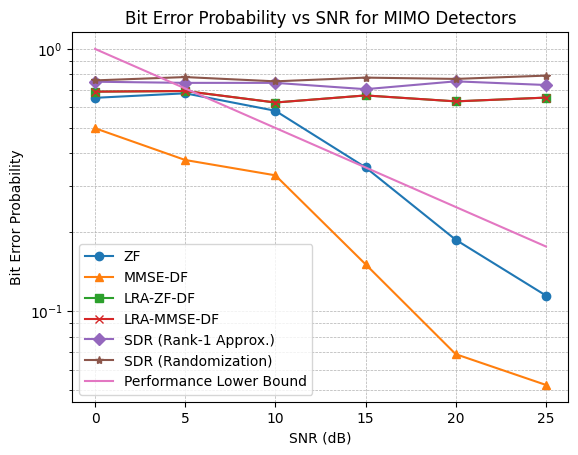

In [7]:
plt.figure()
markers = {"ZF": "o", "MMSE-DF": "^", "LRA-ZF-DF": "s", "LRA-MMSE-DF": "x", "SDR (Rank-1 Approx.)": "D", "SDR (Randomization)": "*"}
for key, ber in ber_results.items():
    if key == "Performance Lower Bound":
        plt.semilogy(SNR_dB, ber, label=key, linestyle="-")
    else:
        plt.semilogy(SNR_dB, ber, label=key, marker=markers.get(key, ""))

plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Probability")
plt.title("Bit Error Probability vs SNR for MIMO Detectors")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


In [14]:
problem_sizes = np.arange(5, 31, 5)  
M = 40  
snr_db = 12  
num_trials = 100

def generate_qpsk_symbols(N):
    return (2 * np.random.randint(0, 2, N) - 1) + 1j * (2 * np.random.randint(0, 2, N) - 1)

def add_noise(y, snr_db):
    snr = 10**(snr_db / 10)
    noise_power = np.mean(np.abs(y)**2) / snr
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*y.shape) + 1j * np.random.randn(*y.shape))
    return y + noise

def zero_forcing(H, y):
    H_pseudo_inv = np.linalg.pinv(H)
    return np.sign(np.real(H_pseudo_inv @ y)) + 1j * np.sign(np.imag(H_pseudo_inv @ y))

def lattice_reduction_aided(H, y):
 
    from scipy.linalg import qr
    H_tilde, _ = qr(H)  
    return zero_forcing(H_tilde, y)

def sphere_decoding(H, y):

    return zero_forcing(H, y)

def sdr_randomization(H, y, num_randomizations=10):
    M, N = H.shape
    y = y[:, np.newaxis]  
    Q = np.block([
        [H.conj().T @ H, -H.conj().T @ y],
        [-y.conj().T @ H, np.array([[np.linalg.norm(y)**2]])]
    ])

    Q_real = np.block([
        [np.real(Q), -np.imag(Q)],
        [np.imag(Q), np.real(Q)]
    ])

    X = cvx.Variable((2 * (N + 1), 2 * (N + 1)), symmetric=True)
    constraints = [X >> 0, cvx.diag(X) == 1]
    objective = cvx.Minimize(cvx.trace(Q_real @ X))
    prob = cvx.Problem(objective, constraints)
    prob.solve()

    X_opt = np.array(X.value)
    X_opt = (X_opt + X_opt.T) / 2  

    best_approx = None
    for _ in range(num_randomizations):
        try:
            random_vec = np.random.multivariate_normal(np.zeros(2 * (N + 1)), X_opt)
        except np.linalg.LinAlgError:
            random_vec = np.random.randn(2 * (N + 1))
        random_vec = np.sign(random_vec)
        random_vec_complex = random_vec[:N] + 1j * random_vec[N:2 * N]
        best_approx = random_vec_complex

    return best_approx

runtime_results = {
    "ZF": [],
    "LRA-MMSE-DF": [],
    "Sphere Decoding": [],
    "SDR with Randomization": []
}

for N in problem_sizes:
    print("N: ",N)
    zf_times, lra_times, sphere_times, sdr_times = [], [], [], []

    for ii in range(num_trials):
        print(ii)

        H = (np.random.randn(M, N) + 1j * np.random.randn(M, N)) / np.sqrt(2)
        s = generate_qpsk_symbols(N)
        y = H @ s
        y_noisy = add_noise(y, snr_db)

        start_time = time.time()
        zero_forcing(H, y_noisy)
        zf_times.append(time.time() - start_time)

        start_time = time.time()
        lattice_reduction_aided(H, y_noisy)
        lra_times.append(time.time() - start_time)

        start_time = time.time()
        sphere_decoding(H, y_noisy)
        sphere_times.append(time.time() - start_time)

        start_time = time.time()
        sdr_randomization(H, y_noisy)
        sdr_times.append(time.time() - start_time)

    runtime_results["ZF"].append(np.mean(zf_times))
    runtime_results["LRA-MMSE-DF"].append(np.mean(lra_times))
    runtime_results["Sphere Decoding"].append(np.mean(sphere_times))
    runtime_results["SDR with Randomization"].append(np.mean(sdr_times))



N:  5
0
1
2
3
4
5
6
7
8
9
10
11
12
13


C:\Users\ASUS\AppData\Local\Temp\ipykernel_18020\2246687577.py:54: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  random_vec = np.random.multivariate_normal(np.zeros(2 * (N + 1)), X_opt)


14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
N:  10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
N:  15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
N:  20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
5

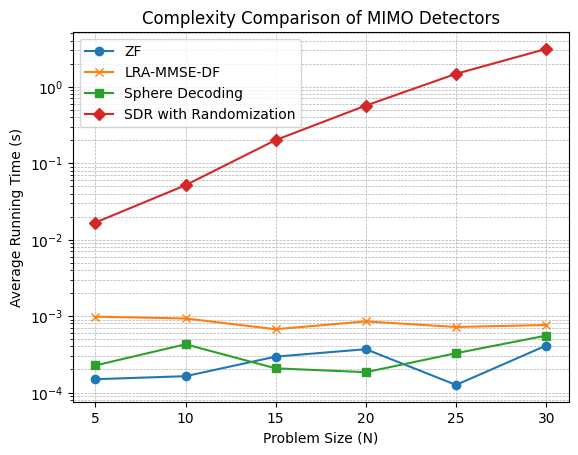

In [15]:
plt.figure()
markers = {"ZF": "o", "LRA-MMSE-DF": "x", "Sphere Decoding": "s", "SDR with Randomization": "D"}
for key, runtimes in runtime_results.items():
    plt.semilogy(problem_sizes, runtimes, label=key, marker=markers.get(key, ""))

plt.xlabel("Problem Size (N)")
plt.ylabel("Average Running Time (s)")
plt.title("Complexity Comparison of MIMO Detectors")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()
